# Notebook to Examine NISAR Station GPS Data
---

This demonstrates and tests the capability of the nisarSation class for working with GPS data processed by JPL for NISAR cryo cal/val activities.

## Python Setup

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import nisargps
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
import pyproj
from scipy.stats import linregress
import calendar
import os

## Load Data

Station data too big for github, so unzip if compressed after downloading.

In [2]:
!ls

L2-SCI-667-September24ST.ipynb	nisarCalValDBGPSDemo-Greenland.ipynb  README.md
LORG				nisarCalValDBGPSDemo.ipynb
LORG.tide.2019			nisarStationDemoNotebook.ipynb


In [3]:
if os.path.exists('LORG/wholeTimeSeriesLLH.noLoad.decYr.txt.gz'):
    !gunzip 'LORG/wholeTimeSeriesLLH.noLoad.decYr.txt.gz'
if os.path.exists('LORG.tide.2019.gz'):
    !gunzip 'LORG.tide.2019.gz'

Setup station id and path.

In [4]:
stationPath = 'LORG/wholeTimeSeriesLLH.noLoad.decYr.txt'
stationName = 'LORG'
stationLORG = nisargps.nisarStation('LORG')

None
Error in: nisarcryodb._initDB 
	Configuration file not found: calvaldb_config.ini
Error in: nisarcryodb.stationNameToID 
	'nisarcryodb' object has no attribute 'cursor'


Load a sample data set. Can be accessed as `stationLORG.x` (or `.y, .z, .lat, .lon, .date, .epoch`), where `date` provides the date as `datetime` array and `epoch` provides the date as a decimal year.

In [5]:
stationLORG.addData(stationPath)


*******************************************
Error in: nisarStation.addData at line 232 
Message: 'NoneType' object is not callable 
*******************************************
 



## Plot Positions

Plot early January trajectory. 

In [6]:
date, x, y, z, epoch = stationLORG.subsetXYZ('2019-01-01', '2019-01-06')
resultx = linregress(epoch, x)
resulty = linregress(epoch, y)
# Compute linear path
xline = resultx[0] * epoch + resultx[1]
yline = resulty[0] * epoch + resulty[1]
#
fig, ax = plt.subplots(1, 1, figsize=(9, 14))
ax.plot(x -x[0], y - y[0], 'r.')
ax.plot(xline-x[0], yline-y[0], 'k', linewidth=2)
ax.set_xlabel('X (m)', fontsize=16)
ax.set_ylabel('Y (m)', fontsize=16)
ax.set_title('Station Trajectory from 2019-01-01 to 2019-01-06', fontsize=14) 
for lab  in ax.get_xticklabels() + ax.get_yticklabels():
    lab.set_fontsize(14)


*************************************************************************
Error in: nisarStation._formatDate at line 333 
Message: time data '2019-01-01' does not match format '%Y-%m-%d %H:%M:%S' 
*************************************************************************
 


*************************************************************************
Error in: nisarStation._formatDate at line 333 
Message: time data '2019-01-06' does not match format '%Y-%m-%d %H:%M:%S' 
*************************************************************************
 


**********************************************************
Error in: nisarStation._datetimeToDecimalYear at line 473 
Message: 'NoneType' object has no attribute 'year' 
**********************************************************
 


**********************************************************
Error in: nisarStation._datetimeToDecimalYear at line 473 
Message: 'NoneType' object has no attribute 'year' 
**********************************************

TypeError: cannot unpack non-iterable NoneType object

## Compute and Plot Time Series

This section demonstrates the estimate of a velocity time series over a given period. There are two methods:
- `point`, which computes the position averaged over some interval (`averagingPeriod`)
- `regression` this method computes the velocity of slope for all the points over the period of interest.

The method is specified with the `method` keyword. Either method generates the series from `date1` to `date2`, sampled at increments of `sampleInterval` hours. Velocities are computed with a `dT` specfied in hours. Further research is needed to best determine the velocity for NISAR cal/val. In this example, the standard deviations of the velocities computed using the two methods are 0.6 and 1.7 m/yr, respectively. The differences arise because of the large diurnal variation in speed on the floating ice. The results should be much better on grounded ice. 

The method and period are specified as:

In [ ]:
#method = 'point'
method = 'regression'
date1 = '2019-01-01'
date2 = '2019-03-01'

Compute velocity at various intervals and over various periods.

In [ ]:
sampleInterval = 4  # Estimate every 4 hours
dTsubDaily = 2  # Compute speed over a 2-hour window
dateSubDaily, vxSubDaily, vySubDaily = stationLORG.computeVelocityTimeSeries(date1, date2, 
                                                                             dTsubDaily, sampleInterval, method=method)

Compute velocity time series at daily intervals.

In [ ]:
sampleInterval = 4 # Estimate every 4 hours
dT = 24  # Compute over a 24 hour interval
dateDaily, vxDaily, vyDaily = stationLORG.computeVelocityTimeSeries(date1, date2,
                                                                    dT, sampleInterval, method=method)

Now compute at daily intervals but with delta T of 12 days.

In [ ]:
sampleInterval = 12 # Estimate every 12 hours
dT = 24 * 12  # Compute speed over 12 day interval
date12, vx12, vy12 = stationLORG.computeVelocityTimeSeries(date1, date2,
                                                           dT, sampleInterval, method=method)

Now Plot the results.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(18, 9))
for date, vx, vy, dTLabel, marker, linewidth in zip([dateSubDaily, dateDaily, date12],
                                         [vxSubDaily, vxDaily, vx12], 
                                         [vySubDaily, vyDaily, vy12],
                                         [f'dT {dTsubDaily} hours', 'dT 1 day', 'dT 12 days'], 
                                         ['-', '-', 'o'], [.5, 1, 1]):
    ax.plot(date, vx, f'r{marker}', label=f'vx {dTLabel}', markersize=4, linewidth=linewidth)
    ax.plot(date, vy, f'b{marker}', label=f'vy {dTLabel}', markersize=4, linewidth=linewidth)
    ax.plot(date, np.sqrt(vx**2 + vy**2), f'k{marker}', label=f'$|v|$ {dTLabel}', markersize=4, linewidth=linewidth)
#
ax.set_ylabel('$v_x$, $v_y$, speed (m/yr', fontsize=18)  
ax.set_xlabel('Date', fontsize=18)
for lab  in ax.get_xticklabels() + ax.get_yticklabels():
    lab.set_fontsize(14)
ax.legend(loc='lower right', ncol=3)

As the results indicate, there is there is a large diurnal variation, which some less clear semi-diurnal varation (Ross tides are largely diurnal). There are a few spikes due to spurious points, which will be cleaned after some updates to the code.

## Comparison With Tide Model

As a quick check on the vertical data, this section compares the vertical signal with data from the CATS tidal model, which were compute elsewhere for 2019. The first step is to read the file:

In [7]:
def decDateToDatetime(decDate):
    year = int(decDate)
    sec = np.rint((decDate - year) *
                          (365 + int(calendar.isleap(year))) * 86400)
    return datetime(year, 1, 1, 0, 0, 0) + timedelta(seconds=sec)
#
with open('LORG/LORG.tide.2019') as fp:
    tTide, zTide = np.transpose([[float(x) for x in line.split()] for line in fp])
#
    dateTide = [decDateToDatetime(x) for x in tTide]

FileNotFoundError: [Errno 2] No such file or directory: 'LORG/LORG.tide.2019'

Now plot the result. 

/opt/conda/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NameError: name 'dateTide' is not defined

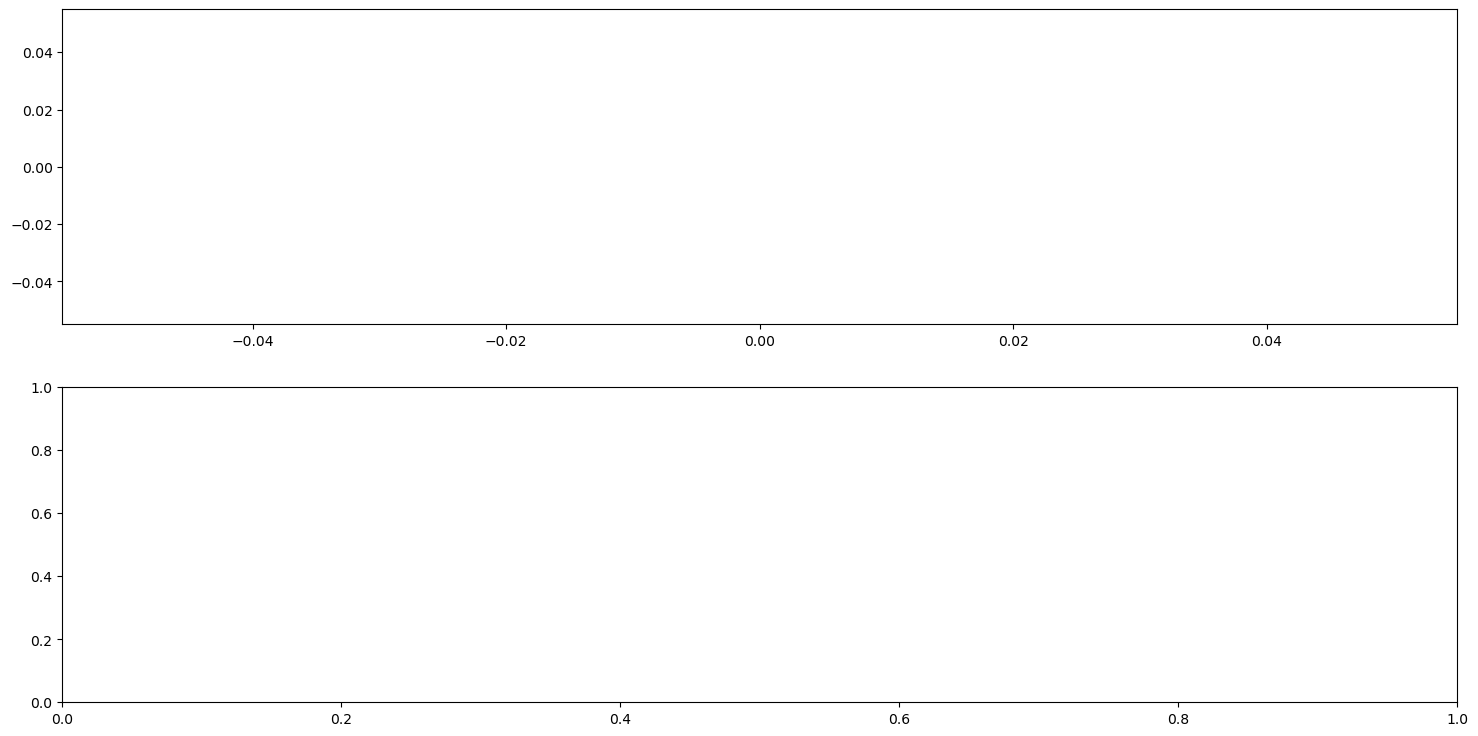

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(18, 9))
# Plot GPS and tide
axes[0].plot(stationLORG.date, stationLORG.z - np.mean(stationLORG.z), label='Tide Model')
axes[0].plot(dateTide, zTide, label='GPS')
# Plot the difference. Interpolate to get on same time grid.
tDiff = stationLORG.z - np.mean(stationLORG.z) - np.interp(stationLORG.epoch, tTide, zTide)
axes[1].plot(stationLORG.date, tDiff, 'r.', markersize=1)
#
for ax, limits in zip(axes, [(-1, 1), (-0.5, 0.5)]):
    ax.set_xlim(datetime(2019, 1, 1), datetime(2019, 3, 1))
    ax.set_ylim(*limits)
    for lab  in ax.get_xticklabels() + ax.get_yticklabels():
        lab.set_fontsize(14)
    ax.set_xlabel('Date', fontsize=16)

Overall the agreement is pretty good. Some of the short term variation may be model error and the longer term stuff is roughly consistent with what might be expacted from the inverse barometer effect (IBE)